# Compare shape metrics

Compare all measured shape metric and explore them and their potential relationships.

In [1]:
import geopandas
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from palettable.cartocolors.qualitative import Bold_6


Set default plotting theme.

In [2]:
sns.set_theme(
    context="paper",
    style="ticks",
    rc={
        "patch.force_edgecolor": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
    },
    palette=Bold_6.hex_colors,
)

Load the data and combine them to a single GeoDataFrame.

In [3]:
sample = geopandas.read_parquet("../data/sample.parquet")

all_poly = []
for i, row in sample.iterrows():
    fua = geopandas.read_parquet(f"../data/{int(row.eFUA_ID)}/polygons/")
    fua["continent"] = row.continent
    fua["country"] = row.Cntry_name
    fua["name"] = row.eFUA_name
    fua.crs = None
    all_poly.append(fua)
all_poly_data = pandas.concat(all_poly).reset_index(drop=True)


Possible plot comparing two metrics.

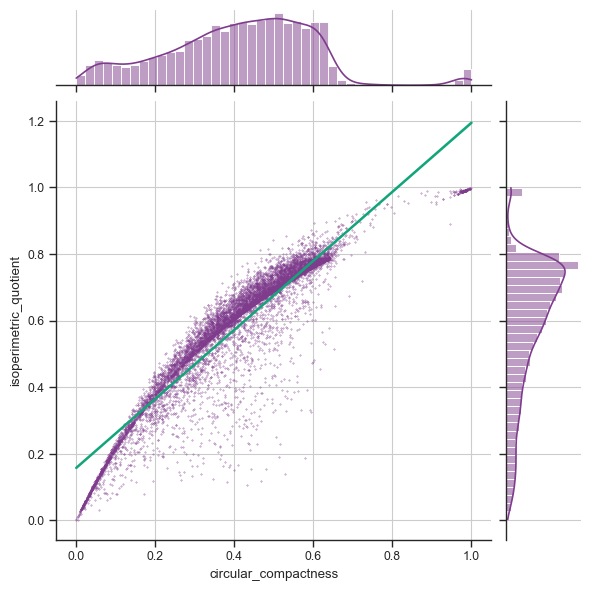

In [4]:
sns.jointplot(
    x="circular_compactness",
    y="isoperimetric_quotient",
    data=all_poly_data.sample(10000, random_state=42),
    kind="reg",
    scatter_kws=dict(s=0.1),
    line_kws=dict(color=Bold_6.mpl_colors[1]),
)

Plot comparing each pair of metrics.

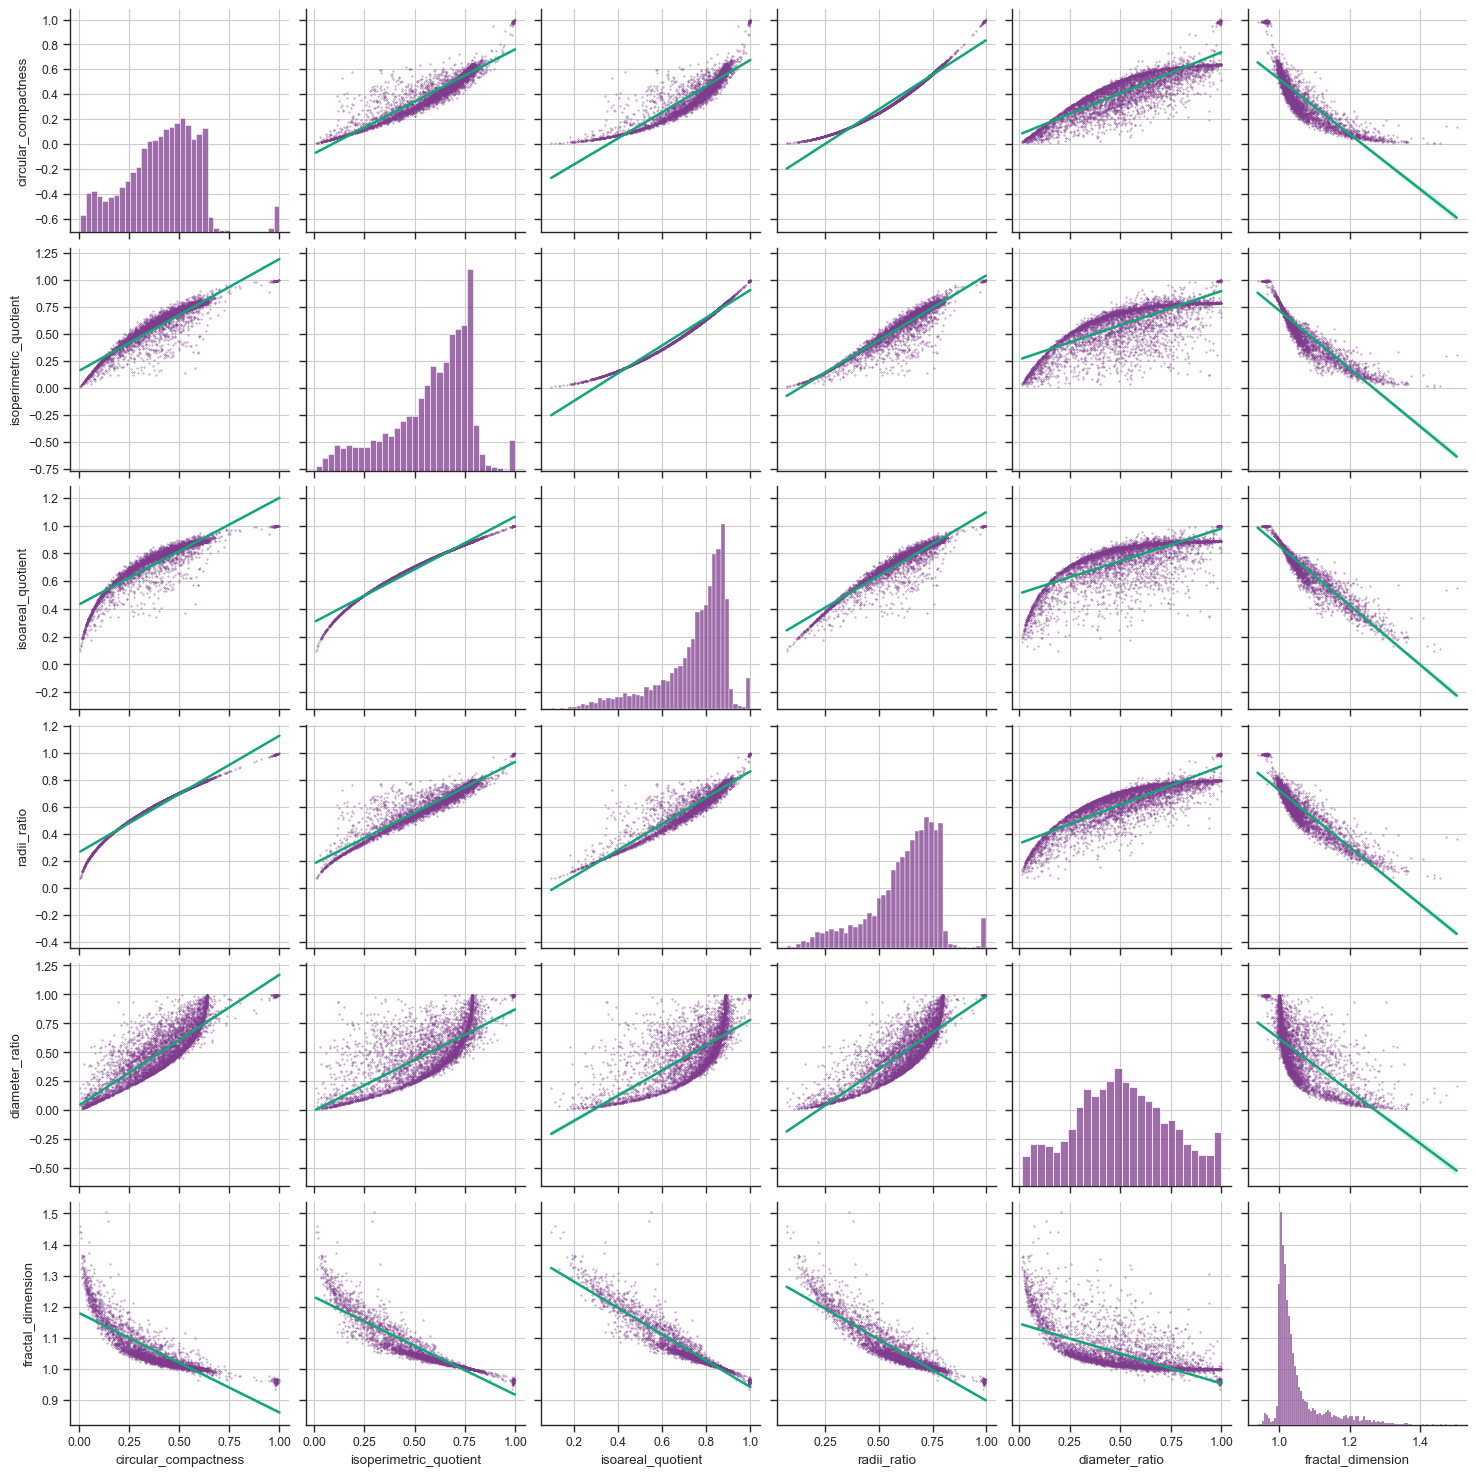

In [5]:
sns.pairplot(
    all_poly_data[
        [
            "circular_compactness",
            "isoperimetric_quotient",
            "isoareal_quotient",
            "radii_ratio",
            "diameter_ratio",
            "fractal_dimension",
        ]
    ].sample(5000, random_state=42),
    kind="reg",
    plot_kws=dict(
        scatter_kws=dict(s=0.1),
        line_kws=dict(color=Bold_6.mpl_colors[1]),
        truncate=True,
        seed=42,
    ),
)

Measure Pearson's correlation

In [6]:
pearson = all_poly_data[
    [
        "circular_compactness",
        "isoperimetric_quotient",
        "isoareal_quotient",
        "radii_ratio",
        "diameter_ratio",
        "fractal_dimension",
    ]
].corr()
pearson.to_csv("../results/pearson.csv")
pearson

,circular_compactness,isoperimetric_quotient,isoareal_quotient,radii_ratio,diameter_ratio,fractal_dimension
circular_compactness,1.000000,0.935327,0.898801,0.979216,0.864704,-0.028651
isoperimetric_quotient,0.935327,1.000000,0.986987,0.955457,0.749779,-0.030928
isoareal_quotient,0.898801,0.986987,1.000000,0.948029,0.716620,-0.030549
radii_ratio,0.979216,0.955457,0.948029,1.000000,0.848114,-0.029938
diameter_ratio,0.864704,0.749779,0.716620,0.848114,1.000000,-0.022091
fractal_dimension,-0.028651,-0.030928,-0.030549,-0.029938,-0.022091,1.000000


Measure Spearman's correlation

In [7]:
spearman = all_poly_data[
    [
        "circular_compactness",
        "isoperimetric_quotient",
        "isoareal_quotient",
        "radii_ratio",
        "diameter_ratio",
        "fractal_dimension",
    ]
].corr("spearman")
spearman.to_csv("../results/spearman.csv")
spearman

,circular_compactness,isoperimetric_quotient,isoareal_quotient,radii_ratio,diameter_ratio,fractal_dimension
circular_compactness,1.000000,0.951406,0.951406,1.000000,0.864185,-0.954688
isoperimetric_quotient,0.951406,1.000000,1.000000,0.951406,0.776799,-0.989646
isoareal_quotient,0.951406,1.000000,1.000000,0.951406,0.776799,-0.989646
radii_ratio,1.000000,0.951406,0.951406,1.000000,0.864185,-0.954688
diameter_ratio,0.864185,0.776799,0.776799,0.864185,1.000000,-0.779020
fractal_dimension,-0.954688,-0.989646,-0.989646,-0.954688,-0.779020,1.000000


## Shape + area indices

Explore distribution of indices capturing relationship between shape metrics and area.

<AxesSubplot: ylabel='Frequency'>

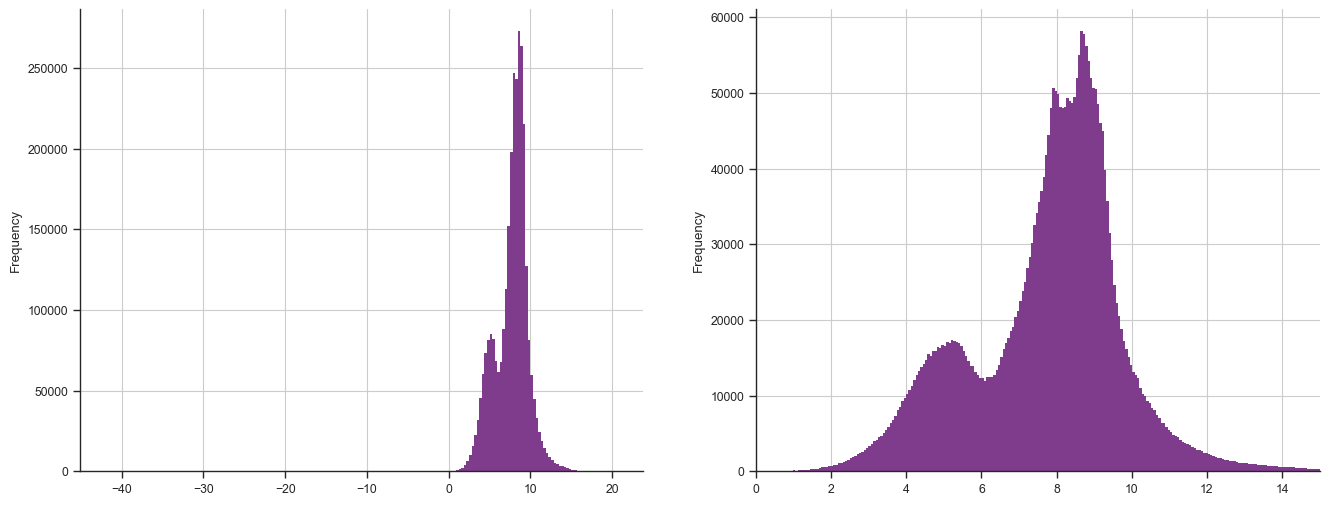

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

numpy.log(all_poly_data.circular_compactness_index).plot.hist(bins=200, ax=axs[0])
numpy.log(all_poly_data.circular_compactness_index).plot.hist(
    bins=1000, xlim=(0, 15), ax=axs[1]
)

<AxesSubplot: ylabel='Frequency'>

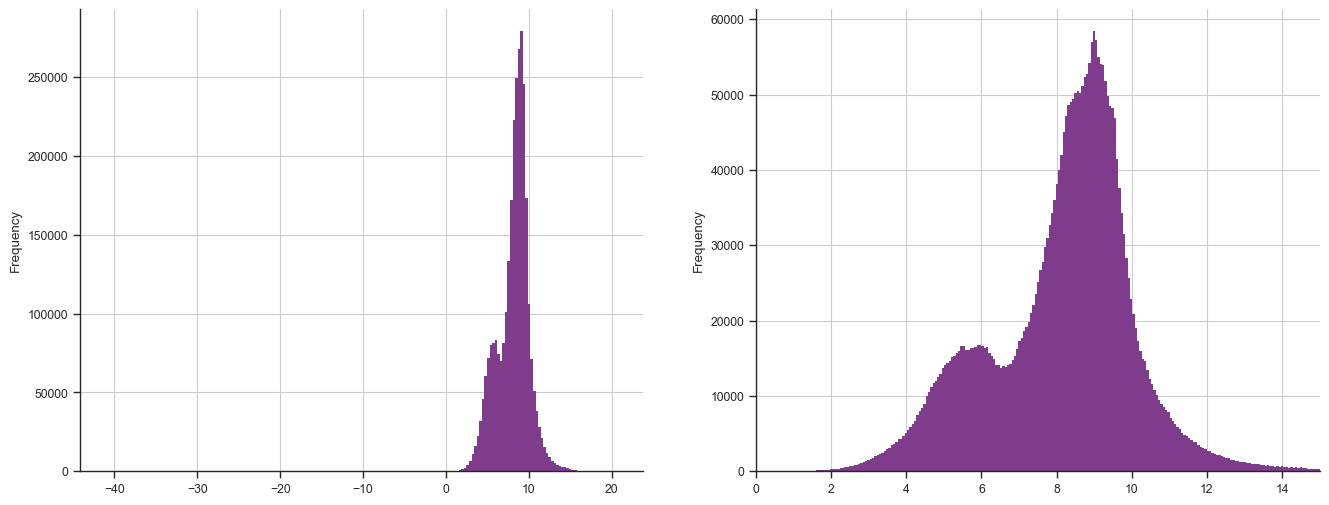

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

numpy.log(all_poly_data.isoperimetric_quotient_index).plot.hist(bins=200, ax=axs[0])
numpy.log(all_poly_data.isoperimetric_quotient_index).plot.hist(
    bins=1000, xlim=(0, 15), ax=axs[1]
)

<AxesSubplot: ylabel='Frequency'>

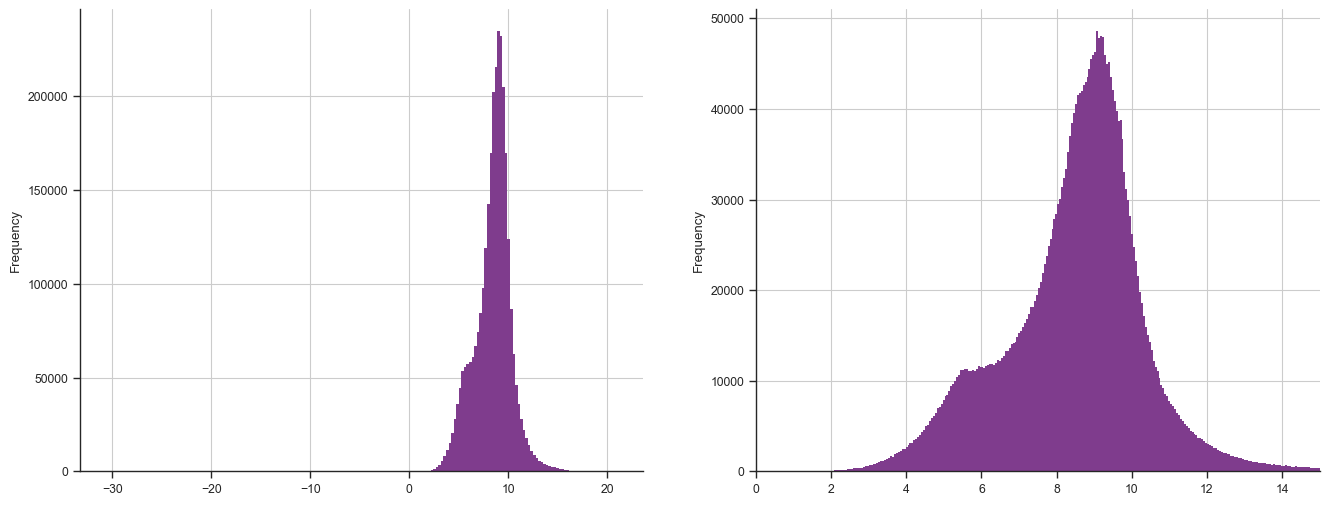

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

numpy.log(all_poly_data.isoareal_quotient_index).plot.hist(bins=200, ax=axs[0])
numpy.log(all_poly_data.isoareal_quotient_index).plot.hist(
    bins=1000, xlim=(0, 15), ax=axs[1]
)

<AxesSubplot: ylabel='Frequency'>

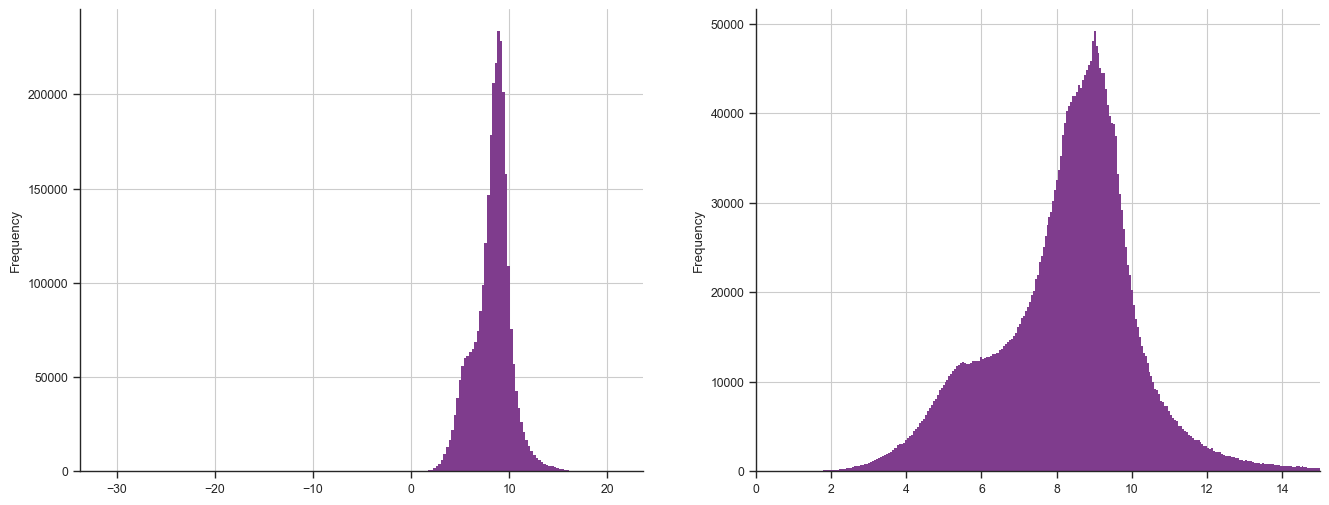

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

numpy.log(all_poly_data.radii_ratio_index).plot.hist(bins=200, ax=axs[0])
numpy.log(all_poly_data.radii_ratio_index).plot.hist(bins=1000, xlim=(0, 15), ax=axs[1])


<AxesSubplot: ylabel='Frequency'>

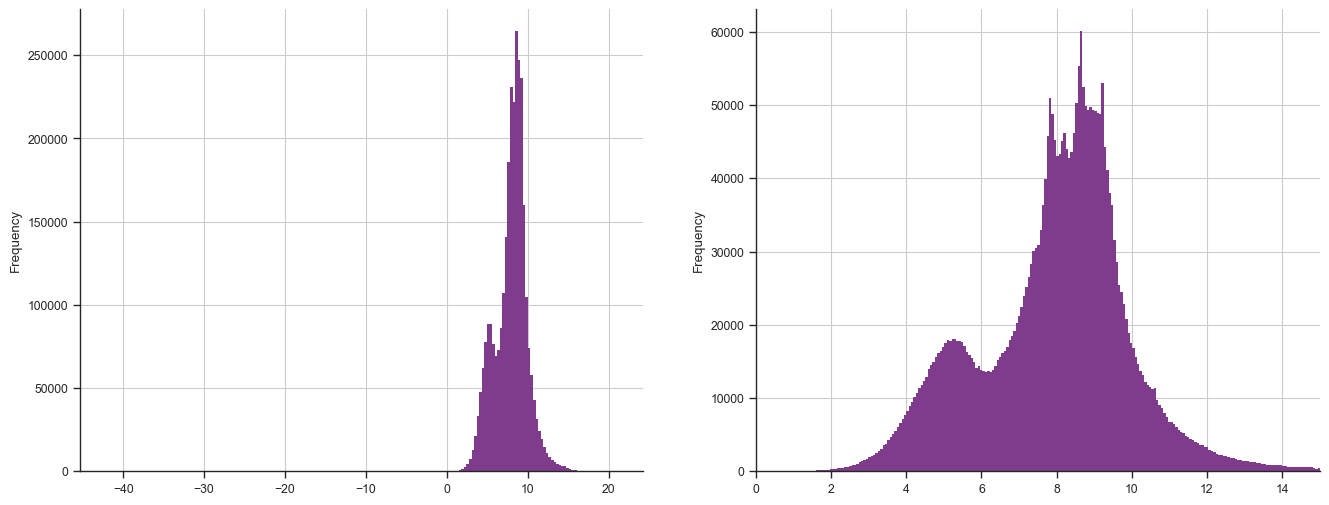

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

numpy.log(all_poly_data.diameter_ratio_index).plot.hist(bins=200, ax=axs[0])
numpy.log(all_poly_data.diameter_ratio_index).plot.hist(
    bins=1000, xlim=(0, 15), ax=axs[1]
)

<AxesSubplot: ylabel='Frequency'>

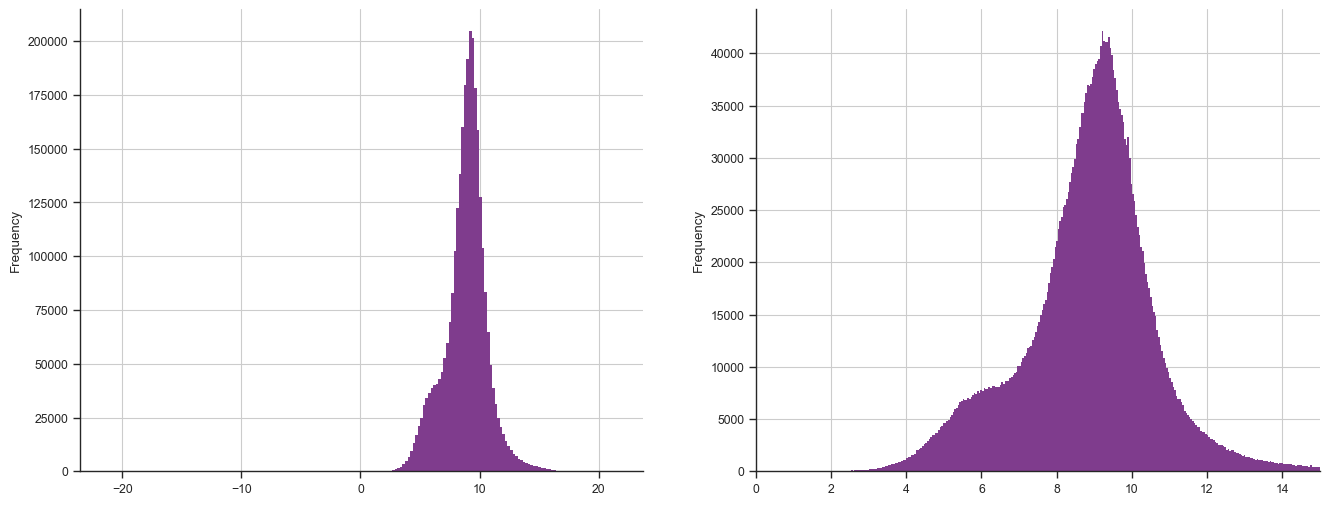

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

numpy.log(all_poly_data.fractal_dimension_index).plot.hist(bins=200, ax=axs[0])
numpy.log(all_poly_data.fractal_dimension_index).plot.hist(
    bins=1000, xlim=(0, 15), ax=axs[1]
)

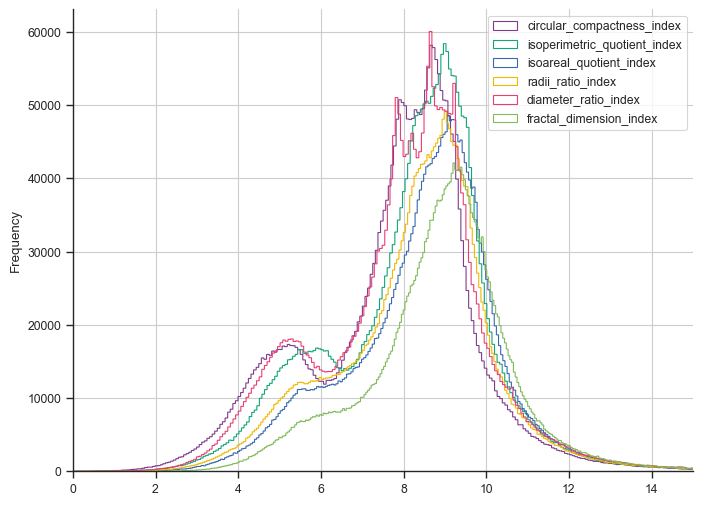

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))
for ix in [c for c in all_poly_data.columns if "index" in c]:
    numpy.log(all_poly_data[ix]).plot.hist(
        bins=1000, xlim=(0, 15), ax=ax, histtype="step"
    )
plt.legend()